In [1]:
# Imports
import os
import json
import tqdm
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

In [3]:
# Load all results and args into this dictionary

model_names = ['WRS2810-40-PL', 'WRS2810-250-PL', 'WRS2810-4000-PL', 'WRS2810-40-PI', 'WRS2810-250-PI', 'WRS2810-4000-PI','WRS2810-40-FS', 'WRS2810-250-FS', 'WRS2810-4000-FS']
#model_names = ['WRS2810-40-PI', 'WRS2810-250-PI', 'WRS2810-4000-PI','WRS2810-40-FS', 'WRS2810-250-FS', 'WRS2810-4000-FS']

root_path = Path('../../../results/ssl/run4/')

results = {mn:{} for mn in model_names}

for model_name in model_names:
    paths = sorted(list(root_path.glob(model_name+"*")))
    for path in tqdm.tqdm(paths):
        with open(path / 'results.json', 'r') as f:
            run_results = json.load(f)
        with open(path / '.hydra/config.yaml') as g:
            conf = yaml.load(g, Loader=yaml.FullLoader)

        results[model_name][path.stem[-1]] = {'results': run_results, 'args': conf}

100%|██████████| 8/8 [00:00<00:00, 217.46it/s]


In [4]:
metrics_to_be_evaluated = {
    'train_history' : ['train_acc1'],
    'test_history' : ['test_acc1']
}

metrics_single = {}
metrics_mean = {}
metrics_std = {}


for model_name in model_names:
    metrics_single[model_name] = {}
    metrics_mean[model_name] = {}
    metrics_std[model_name] = {}
    for history, metrics in metrics_to_be_evaluated.items():
        for metric in metrics:
            metrics_single[model_name][metric] = {}
            metric_values_all = []
            for seed, run_results in results[model_name].items():
                metric_values = []
                for iteration in run_results['results'][history]:
                    metric_values.append(iteration[metric])
                metrics_single[model_name][metric][seed] = metric_values
                metric_values_all.append(metric_values)
            metrics_mean[model_name][metric] = np.mean(np.array(metric_values_all), axis=0)
            metrics_std[model_name][metric] = np.std(np.array(metric_values_all), axis=0)

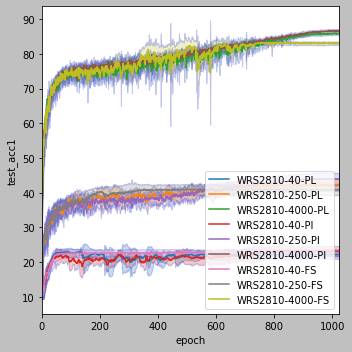

In [5]:
# Choice of Demonstration for test stats
metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(5,5), facecolor='silver', edgecolor='black', tight_layout=True)

for model, label in zip(model_names, model_names):
    plt.plot(metrics_mean[model][metric], label=label)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(metrics_mean[model][metric]))], 
            y1=metrics_mean[model][metric]+abs(metrics_std[model][metric]), 
            y2=metrics_mean[model][metric]-abs(metrics_std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='lower right')
plt.xlim(0, len(metrics_mean[model][metric])-1)
plt.xlabel('epoch')
plt.ylabel(metric)
plt.show()

In [6]:
# BestAcc Table
best_accs_mean = {}
best_accs_std = {}
for model_name in model_names:
    best_model_accs = []
    for seed, run_results in results[model_name].items():
        test_history = run_results['results']['test_history']
        best_model_accs.append(max([stats['test_acc1'] for stats in test_history]))
    best_accs_mean[model_name] = np.mean(np.array(best_model_accs))
    best_accs_std[model_name] = np.std(np.array(best_model_accs))

best_accs = {
    mn : {} for mn in ["supervised", "pimodel", "pseudolabels"]
}

for model_name in model_names:
    if "-PI" in model_name:
        mn = "pimodel"
    elif "-PL" in model_name:
        mn = "pseudolabels"
    elif "-FS" in model_name:
        mn = "supervised"

    if "-40-" in model_name:
        ds = "cifar_40"
    elif "-250-" in model_name:
        ds = "cifar_250"
    elif "-4000-" in model_name:
        ds = "cifar_4000"

    best_accs[mn][ds] = str(np.round(100 - best_accs_mean[model_name], 2))+" +/- "+str(np.round(best_accs_std[model_name], 2))

pd.DataFrame(best_accs).T

,cifar_40,cifar_250,cifar_4000
supervised,76.89 +/- 0.98,58.59 +/- 1.45,16.15 +/- 0.34
pimodel,75.43 +/- 1.15,55.74 +/- 1.82,13.1 +/- 0.49
pseudolabels,75.93 +/- 0.89,56.99 +/- 1.61,13.88 +/- 0.34


In [7]:
final_accs = {
    mn : {} for mn in ["supervised", "pimodel", "pseudolabels"]
}

for model_name in model_names:
    if "-PI" in model_name:
        mn = "pimodel"
    elif "-PL" in model_name:
        mn = "pseudolabels"
    elif "-FS" in model_name:
        mn = "supervised"

    if "-40-" in model_name:
        ds = "cifar_40"
    elif "-250-" in model_name:
        ds = "cifar_250"
    elif "-4000-" in model_name:
        ds = "cifar_4000"

    final_accs[mn][ds] = str(np.round(100 - metrics_mean[model_name]['test_acc1'][-1], 2))+" +/- "+str(np.round(metrics_std[model_name]['test_acc1'][-1], 2))

pd.DataFrame(final_accs).T

,cifar_40,cifar_250,cifar_4000
supervised,77.21 +/- 0.93,59.11 +/- 1.47,16.96 +/- 0.54
pimodel,76.85 +/- 1.53,56.02 +/- 1.72,13.46 +/- 0.61
pseudolabels,77.8 +/- 1.22,57.65 +/- 1.73,14.15 +/- 0.38
